AVANT UTILISATION XGBOOST : sous-échantillonnage et sur-échantillonnage

XGBOOST + shapvalues = intéressant
regarde code cash prediction


In [2]:
import pandas as pd
import numpy as np
import pickle
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


Rééquilibrage echantillon

In [ ]:
def feature_selection(X_train, y_train, param_grid, top_n=20):
    """
    Sélectionne les top_n meilleures features selon l'importance du modèle XGBoost.
    """
    # Grid search pour trouver les meilleurs paramètres
    gr_cv = GridSearchCV(XGBClassifier(random_state=42, n_jobs=-1),
                         param_grid,
                         cv=5,
                         scoring='neg_mean_absolute_error')
    gr_cv.fit(X_train, y_train)
    best_params = gr_cv.best_params_
    # Entraînement du modèle avec les meilleurs paramètres
    model = Pipeline([
        ('num_imputer', SimpleImputer(strategy='mean')),
        ('xgb_model', XGBClassifier(**best_params))
    ])
    model.fit(X_train, y_train)
    # Importance des features
    importances = model.named_steps['xgb_model'].feature_importances_
    features = X_train.columns
    feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
    selected_features = feat_imp.head(top_n).index.tolist()
    return selected_features, feat_imp, model

In [3]:
data = pd.read_csv('../data/processed/data/data_preprocessed.csv')
with open("label_encoders.pkl", "rb") as f:
    loaded_encoders = pickle.load(f)

In [4]:
data.shape

(189850, 69)

In [5]:
features = data.columns.drop('Mental Illness').tolist()
target = 'Mental Illness'
X = data[features]
y = data[target]

ESSAI PCA

In [6]:
print("Original dataset distribution:", Counter(y))

# 2. Random Undersampling
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X, y)
print("After undersampling:", Counter(y_under))

# 3. SMOTE Oversampling
smote = SMOTE(random_state=42)
X_over, y_over = smote.fit_resample(X, y)
print("After oversampling (SMOTE):", Counter(y_over))

Original dataset distribution: Counter({True: 184415, False: 5435})
After undersampling: Counter({False: 5435, True: 5435})


c:\Users\maud.busserolles\OneDrive - VINCI Energies\Bureau\Projet_Mental_Illness\Mental-Illness-Prediction\.venv\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\maud.busserolles\OneDrive - VINCI Energies\Bureau\Projet_Mental_Illness\Mental-Illness-Prediction\.venv\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\maud.busserolles\OneDrive - VINCI Energies\Bureau\Projet_Mental_Illness\Mental-Illness-Prediction\.venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of

After oversampling (SMOTE): Counter({True: 184415, False: 184415})


In [ ]:
param_grid = {'n_estimators': [100, 300],
                'max_depth': [3, 5, 10],
                'min_child_weight': [1, 3, 5],
                'learning_rate':[0.1],
                'n_jobs':[-1]}

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

In [ ]:
selected_features, feat_imp, model = feature_selection(X_train, y_train, param_grid, top_n=20)
print("Top features :", selected_features)
print("Importances :", feat_imp)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
conf_matrix

In [ ]:
class_report = classification_report(y_test, y_pred)
print("Confusion Matrix:\n", class_report)

In [8]:
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
model.fit(X_train, y_train)
 

RandomForestClassifier(class_weight='balanced', random_state=42)

In [9]:
y_pred = model.predict(X_test)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

✅ Accuracy: 0.9562264457880324

📊 Classification Report:
               precision    recall  f1-score   support

       False       0.93      0.98      0.96     36804
        True       0.98      0.93      0.96     36962

    accuracy                           0.96     73766
   macro avg       0.96      0.96      0.96     73766
weighted avg       0.96      0.96      0.96     73766



In [10]:
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)
print("\n🔍 Feature Importances:\n", feature_importance_df)


🔍 Feature Importances:
                          Feature  Importance
52           SSI Cash Assistance    0.074263
1                  Region Served    0.056665
0               Program Category    0.046422
53          SSDI Cash Assistance    0.042559
7                           Race    0.041389
..                           ...         ...
34                Kidney Disease    0.001118
30                        Stroke    0.000657
29                  Heart Attack    0.000524
54  Veterans Disability Benefits    0.000311
55      Veterans Cash Assistance    0.000089

[68 rows x 2 columns]


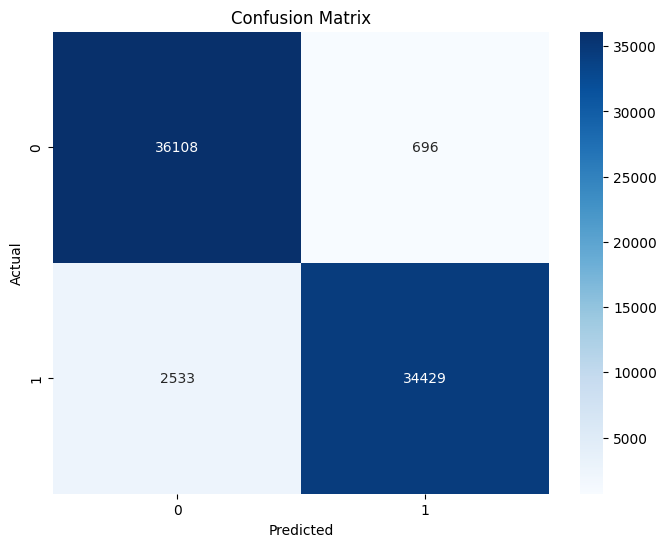

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [12]:
with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(model, f)
print("Modèle et encoders sauvegardés.")

Modèle et encoders sauvegardés.


In [19]:
y_test

335607    False
110733     True
120339     True
253732    False
88489      True
          ...  
352550    False
298375    False
326633    False
233588    False
279235    False
Name: Mental Illness, Length: 73766, dtype: bool

In [ ]:
with open("random_forest_model.pkl", "rb") as f:    
    loaded_model = pickle.load(f)
with open("label_encoders.pkl", "rb") as f:
    loaded_encoders = pickle.load(f)
sample_data = X_test.iloc[2:3]
predicted_class = loaded_model.predict(sample_data)
predicted_class_label = loaded_encoders["Mental Illness"].inverse_transform(predicted_class)
print("Prediction pour un échantillon:", predicted_class_label[0])

Prediction pour un échantillon: YES


In [21]:
# Exemple : prédire à partir d'une valeur entrée par l'utilisateur pour une variable

# 1. Choisir la variable à tester
variable = "Sex"  # Remplace par le nom de ta variable

# 2. Entrer la valeur à prédire
valeur = input(f"Entrez la valeur pour {variable} : ")

# 3. Créer un échantillon avec cette valeur (et valeurs par défaut pour les autres)
sample = X_test.iloc[0:1].copy()  # Copie une ligne existante pour garder la structure
sample[variable] = valeur

# 4. Prédire avec le modèle chargé
prediction = model.predict(sample)[0]

# 5. Afficher le résultat
print(f"Prédiction pour {variable} = {valeur} : {prediction}")

Prédiction pour Sex = 0 : False
